# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/tree/master/data_schema_references/. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [153]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
#from tensorflow.data import DataVlidation
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/tree/master/project/data_schema_references/.

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path).replace(["?"],np.nan)

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [5]:
print("dataset shape",df.shape)
print("number of unique encounters",df["encounter_id"].nunique())
print("number of unique patients",df["patient_nbr"].nunique())
unique_encounters=df["encounter_id"].nunique()
df.info()

dataset shape (143424, 26)
number of unique encounters 101766
number of unique patients 71518
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143424 entries, 0 to 143423
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              143424 non-null  int64 
 1   patient_nbr               143424 non-null  int64 
 2   race                      140115 non-null  object
 3   gender                    143424 non-null  object
 4   age                       143424 non-null  object
 5   weight                    4302 non-null    object
 6   admission_type_id         143424 non-null  int64 
 7   discharge_disposition_id  143424 non-null  int64 
 8   admission_source_id       143424 non-null  int64 
 9   time_in_hospital          143424 non-null  int64 
 10  payer_code                89234 non-null   object
 11  medical_specialty         73961 non-null   object
 12  primary_diagnosis_co

## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

Student Response: The data is presented in the line level because the number of unique encounters is less than the dataset rows. 
the keys that we should aggregate on are all the keys that doesn't change per encounter if we will use one encounter for each patient from the dataset. from the schema, this keys are :
- encounter_id
- patient_nbr 
- number_intpatient
- number_outpatient
- number_emergency
- num_lab_procedures
- num_medications
- num_procedures
- race
- age
- gender

these were the keys stated in the dataset schema which are fixed per encounter. After investigating the dataset, it was found that all the feature keys are fixed per encounter except the "ndc_code"


## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

**Student Response**: 

a- I- keys with high amout of missing values :
- weight(139122)
- medical_specialty(69463)
- payer_code(54190)
- ndc_code(23462)
 II- keys with high amout of zero values:
  - number_outpatient(120027)
  - number_inpatient(96698)
  - number_emergency(127444)

b- these numerical features have a Gaussian response:
- num_lab_procedures
- num_medications
- time_in_hospital

c- keys with high cardinality are:
- primary_diagnosis_code(716)
- other_diagnosis_codes(19374)
- ndc_code(251)
- medical_specialty(72)

This high cardinality is either because these keys are used to identify the patient, encounter, and will not be used as features or these keys have many combinations like the procedure, medication, and diagnosis codesets.

d- the demographic distribution in the dataset shows that most of the dataset patients are in above the 40 years and this may be normal because of the high infection rate above this age, the distribution of the gender through the data set almost has no bias except in the 80-90 age bin which is biased toward the female patients.


In [6]:
######NOTE: The visualization will only display in Chrome browser. ########

###a.
print("null values count\n",df.isnull().sum())
print("\n zero values count\n",df.isin([0]).sum())

null values count
 encounter_id                     0
patient_nbr                      0
race                          3309
gender                           0
age                              0
weight                      139122
admission_type_id                0
discharge_disposition_id         0
admission_source_id              0
time_in_hospital                 0
payer_code                   54190
medical_specialty            69463
primary_diagnosis_code          33
other_diagnosis_codes            0
number_outpatient                0
number_inpatient                 0
number_emergency                 0
num_lab_procedures               0
number_diagnoses                 0
num_medications                  0
num_procedures                   0
ndc_code                     23462
max_glu_serum                    0
A1Cresult                        0
change                           0
readmitted                       0
dtype: int64

 zero values count
 encounter_id                     0
pa

In [7]:
data_schema=pd.read_csv("project_data_schema.csv")
data_schema

,Feature Name\n,Type,Description
0,encounter_id,numeric ID\n,Unique identifier of an encounter
1,patient_nbr,numeric ID\n,Unique identifier of a patient
2,race,categorical,"Values: Caucasian, Asian, African American, Hi..."
3,gender,categorical,"Values: male, female, and unknown/invalid"
4,age,bucketed numerical feature (converted to categ...,"Grouped in 10-year intervals: [0, 10), [10, 20..."
5,weight,numerical,Weight in pounds.
6,admission_type_id,categorical,Integer identifier corresponding to 9 distinct...
7,discharge_disposition_id,categorical,Integer identifier corresponding to 29 distinc...
8,admission_source_id,categorical,nteger identifier corresponding to 21 distinct...
9,time_in_hospital,numerical,Integer number of days between admission and d...


In [8]:
# categorical_features=data_schema[data_schema["Type"].isin(["categorical","categorical array","categorical\n"])]["Feature Name\n"].unique()

# numerical_features=data_schema[data_schema["Type"].isin(["numerical","numerical\n","numeric ID\n",])]["Feature Name\n"].unique()
#'encounter_id', 'patient_nbr'
numerical_features=['time_in_hospital','number_outpatient', 'number_inpatient',
                    'number_emergency','num_lab_procedures', 'number_diagnoses',
                    'num_medications','num_procedures']
categorical_features=['weight','race','age', 'gender',
                      'admission_type_id', 'discharge_disposition_id','admission_source_id',
                      'payer_code','medical_specialty','primary_diagnosis_code', 'other_diagnosis_codes',
                      'ndc_code','max_glu_serum', 'A1Cresult', 'change']


In [9]:
######   b.numerical features histogram
import seaborn as sns

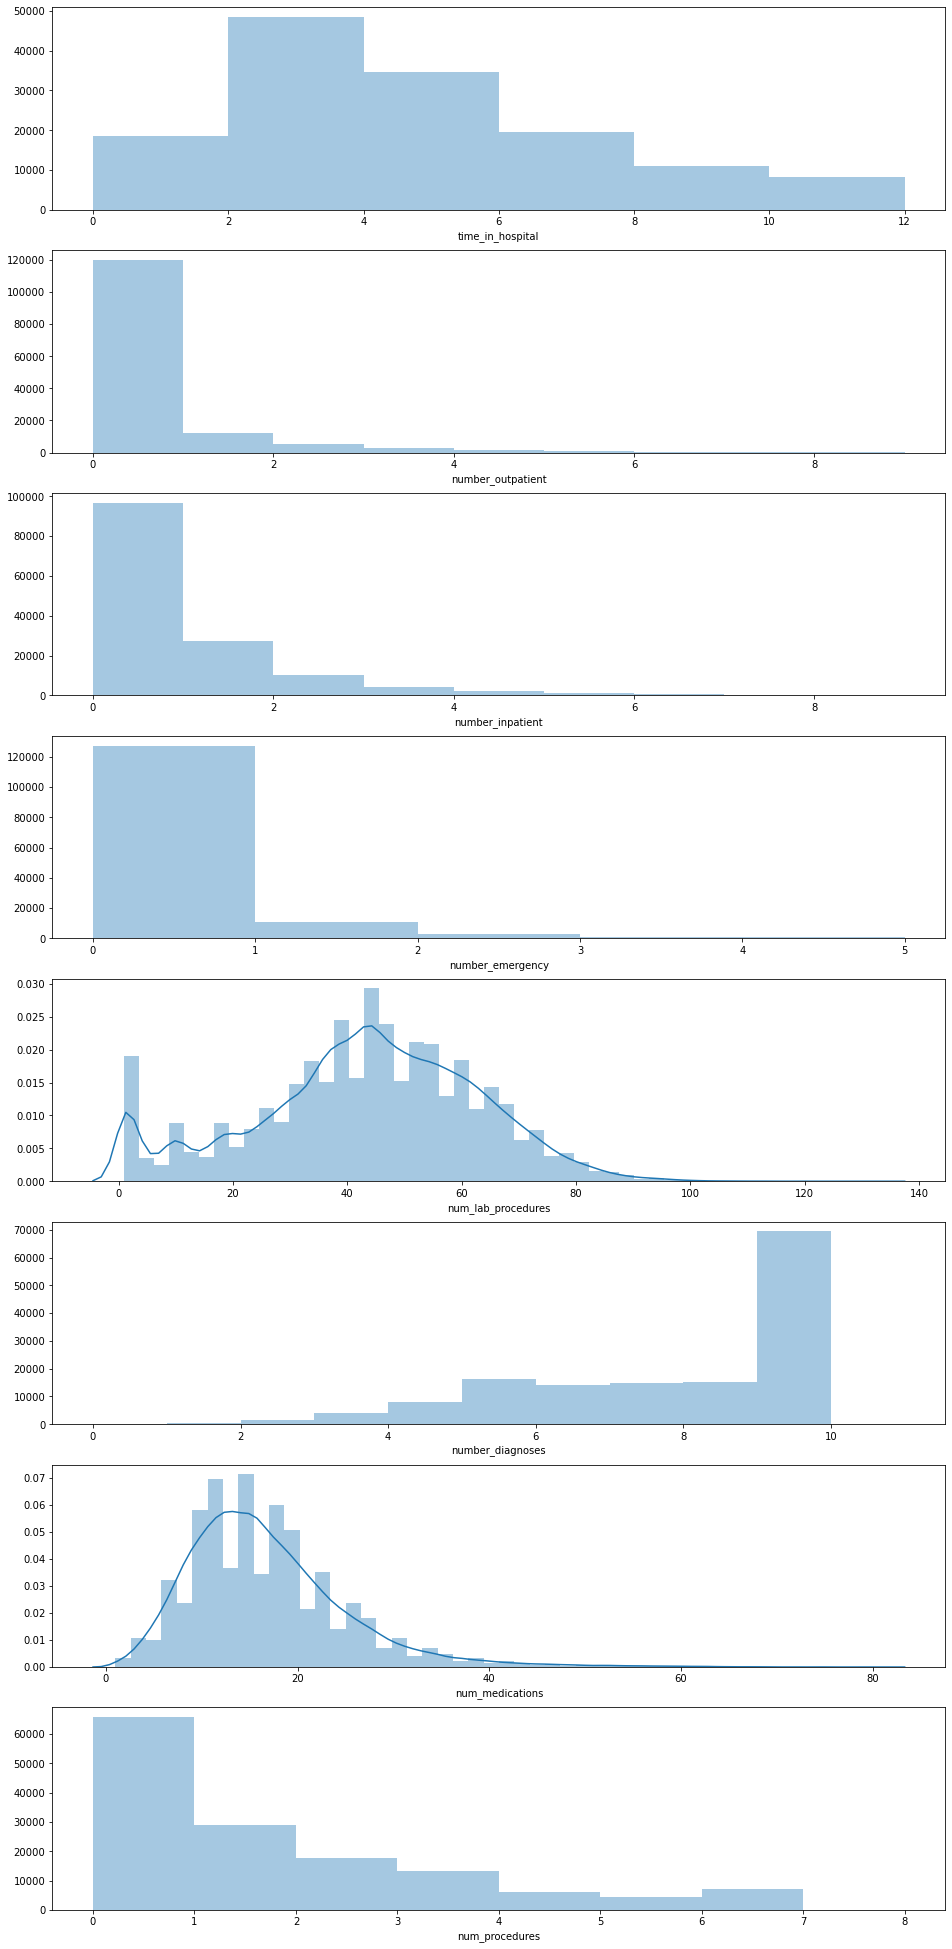

In [10]:
fig, axs = plt.subplots(ncols=1,nrows=8,figsize=(16,35))

# fig.figsize=(12, 6)
#sns.countplot(data=cleaned_df,x="encounter_id", ax=axs[0])
#sns.countplot(cleaned_df["patient_nbr"], ax=axs[1])
time_bins=[x*2 for x in range(7)]
#print(time_bins)
sns.distplot(df["time_in_hospital"],bins=time_bins, ax=axs[0],kde=False)
sns.distplot(df["number_outpatient"], ax=axs[1],kde=False,bins=[x*1 for x in range(10)])
sns.distplot(df["number_inpatient"], ax=axs[2],kde=False,bins=[x*1 for x in range(10)])
sns.distplot(df["number_emergency"], ax=axs[3],kde=False,bins=[x*1 for x in range(6)])
sns.distplot(df["num_lab_procedures"], ax=axs[4])
sns.distplot(df["number_diagnoses"], ax=axs[5],kde=False,bins=[x for x in range(12)])
sns.distplot(df["num_medications"], ax=axs[6])
sns.distplot(df["num_procedures"], ax=axs[7],kde=False,bins=[x for x in range(9)])
#sns.countplot(df["weight"], ax=axs[8],kde=False,bins=[x for x in range(9)])

In [11]:
#   c.cardinality check

df[categorical_features].nunique()

weight                          9
race                            5
age                            10
gender                          3
admission_type_id               8
discharge_disposition_id       26
admission_source_id            17
payer_code                     17
medical_specialty              72
primary_diagnosis_code        716
other_diagnosis_codes       19374
ndc_code                      251
max_glu_serum                   4
A1Cresult                       4
change                          2
dtype: int64

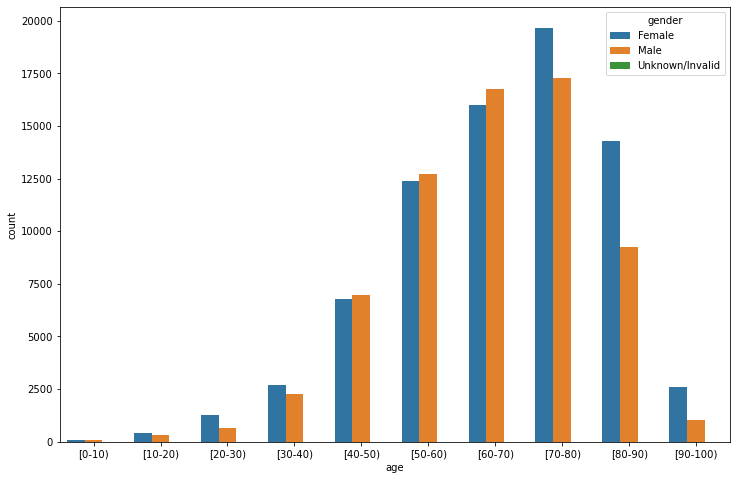

In [12]:
######## d. the demographic distrubution ######## 
fig2, axs2 = plt.subplots(ncols=1,nrows=1,figsize=(12,8))
x=sns.countplot(x="age", hue="gender", data=df,ax=axs2)

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/tree/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [13]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)
ndc_code_df

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
...,...,...,...,...,...,...,...
264,0781-5635,Pioglitazone Hydrochloride And Glimepiride,Pioglitazone Hydrochloride And Glimepiride,Tablet,Oral,Sandoz Inc,Human Prescription Drug
265,64764-302,Duetact,Pioglitazone And Glimepiride,Tablet,Oral,"Takeda Pharmaceuticals America, Inc.",Human Prescription Drug
266,64764-304,Duetact,Pioglitazone And Glimepiride,Tablet,Oral,"Takeda Pharmaceuticals America, Inc.",Human Prescription Drug
267,66993-821,Pioglitazone And Glimepiride,Pioglitazone And Glimepiride,Tablet,Oral,Prasco Laboratories,Human Prescription Drug


In [14]:
ndc_code_df.nunique()

NDC_Code                267
Proprietary Name         39
Non-proprietary Name     24
Dosage Form               9
Route Name                2
Company Name             68
Product Type              1
dtype: int64

In [15]:
from student_utils import reduce_dimension_ndc

In [16]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [17]:
ndc_code_df[ndc_code_df["NDC_Code"]=="47918-902"]

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
261,47918-902,Afrezza,Insulin Human,Kit,NaN,Mannkind Corporation,Human Prescription Drug


In [18]:
reduce_dim_df["generic_drug_name"].nunique()

22

In [19]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [20]:
from student_utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [21]:
#reduce_dim_enc.head(20)
print(first_encounter_df["patient_nbr"].nunique())
print(first_encounter_df["encounter_id"].nunique())

71518
71518


In [22]:
reduce_dim_df[reduce_dim_df["patient_nbr"]==41088789]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
82331,167593854,41088789,Caucasian,Male,[70-80),NaN,1,1,7,3,MC,NaN,486,276|401,0,0,0,43,5,9,0,33342-239,None,None,No,>30,Metformin Hydrochloride
107056,230612106,41088789,Caucasian,Male,[70-80),NaN,1,1,7,1,MC,NaN,530,285|250,0,1,0,29,7,2,2,NaN,None,None,No,>30,NaN
143418,443854148,41088789,Caucasian,Male,[70-80),NaN,1,1,7,1,MC,NaN,38,590|296,1,0,0,53,13,9,0,10631-019,None,None,Ch,NO,Metformin Hydrochloride
143419,443854148,41088789,Caucasian,Male,[70-80),NaN,1,1,7,1,MC,NaN,38,590|296,1,0,0,53,13,9,0,47918-902,None,None,Ch,NO,Insulin Human


In [23]:
##test
first_encounter_df[first_encounter_df["patient_nbr"]==41088789]

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
82331,167593854,41088789,Caucasian,Male,[70-80),NaN,1,1,7,3,MC,NaN,486,276|401,0,0,0,43,5,9,0,33342-239,None,None,No,>30,Metformin Hydrochloride


In [24]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

### Note: that performing the grouping on a rows with null values will remove this rows from the dataset, so removing or imputing these values was required to be done before the grouping step


In [25]:
first_encounter_df.isna().sum()

encounter_id                    0
patient_nbr                     0
race                         2849
gender                          0
age                             0
weight                      97887
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  42374
medical_specialty           48566
primary_diagnosis_code         19
other_diagnosis_codes           0
number_outpatient               0
number_inpatient                0
number_emergency                0
num_lab_procedures              0
number_diagnoses                0
num_medications                 0
num_procedures                  0
ndc_code                    17247
max_glu_serum                   0
A1Cresult                       0
change                          0
readmitted                      0
generic_drug_name           17247
dtype: int64

In [26]:
df_l=first_encounter_df.drop("weight",axis='columns')
df_l=df_l.drop("payer_code",axis='columns')
df_l=df_l.drop("medical_specialty",axis='columns')
df_l=df_l[df_l['race'].notna()]
df_l= df_l[df_l['primary_diagnosis_code'].notna()]
#df_l['other_diagnosis_codes']= df_l['other_diagnosis_codes'].apply(lambda x: x.split("|") if x is not np.nan else [])

In [27]:
df_l.head(20)

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO,NaN
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30,Human Insulin
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO,Glipizide
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO,Human Insulin
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,Glipizide
5,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,197,157|250,0,0,0,51,5,8,0,68071-1701,None,None,Ch,NO,Human Insulin
6,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,414,411|250,0,0,0,31,9,16,6,47918-902,None,None,No,>30,Insulin Human
7,55842,84259809,Caucasian,Male,[60-70),3,1,2,4,414,411|V45,0,0,0,70,7,21,1,35208-001,None,None,Ch,NO,Metformin Hydrochloride
8,55842,84259809,Caucasian,Male,[60-70),3,1,2,4,414,411|V45,0,0,0,70,7,21,1,16729-001,None,None,Ch,NO,Glimepiride
9,55842,84259809,Caucasian,Male,[60-70),3,1,2,4,414,411|V45,0,0,0,70,7,21,1,47918-891,None,None,Ch,NO,Insulin Human


In [28]:
df_l.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
primary_diagnosis_code          0
other_diagnosis_codes           0
number_outpatient               0
number_inpatient                0
number_emergency                0
num_lab_procedures              0
number_diagnoses                0
num_medications                 0
num_procedures                  0
ndc_code                    16873
max_glu_serum                   0
A1Cresult                       0
change                          0
readmitted                      0
generic_drug_name           16873
dtype: int64

In [29]:
def aggregate_dataset(df, grouping_field_list,  array_field):
    df = df.groupby(grouping_field_list)['encounter_id', 
            array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={
    0: array_field + "_array"}) 
    
    dummy_df = pd.get_dummies(df[array_field + '_array'].apply(pd.Series).stack()).sum(level=0)
    dummy_col_list = [x.replace(" ", "_") for x in list(dummy_df.columns)] 
    mapping_name_dict = dict(zip([x for x in list(dummy_df.columns)], dummy_col_list ) ) 
    concat_df = pd.concat([df, dummy_df], axis=1)
    new_col_list = [x.replace(" ", "_") for x in list(concat_df.columns)] 
    concat_df.columns = new_col_list

    return concat_df, dummy_col_list

In [30]:
exclusion_list = ['generic_drug_name',"ndc_code"]
grouping_field_list = [c for c in df_l.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(df_l, grouping_field_list, 'generic_drug_name')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
# df_l=first_encounter_df.drop("weight",axis='columns')
# df_l=df_l.drop("payer_code",axis='columns')
# df_l=df_l.drop("medical_specialty",axis='columns')
# df_l.head(10)
# non_grouping=["ndc_code","generic_drug_name"]
# grouping_field_list=[x for x in df_l.columns if x not in non_grouping]
# gr_df=df_l.groupby(grouping_field_list)
agg_drug_df["patient_nbr"].nunique()

69560

In [32]:
agg_drug_df=agg_drug_df.drop(agg_drug_df[agg_drug_df["gender"]=='Unknown/Invalid'].index)
agg_drug_df["other_diagnosis_codes"]=agg_drug_df["other_diagnosis_codes"].replace("?|?",np.nan)
#agg_drug_df.head(10)
agg_drug_df.isna().sum()

encounter_id                                      0
patient_nbr                                       0
race                                              0
gender                                            0
age                                               0
admission_type_id                                 0
discharge_disposition_id                          0
admission_source_id                               0
time_in_hospital                                  0
primary_diagnosis_code                            0
other_diagnosis_codes                           229
number_outpatient                                 0
number_inpatient                                  0
number_emergency                                  0
num_lab_procedures                                0
number_diagnoses                                  0
num_medications                                   0
num_procedures                                    0
max_glu_serum                                     0
A1Cresult   

In [128]:

agg_drug_df['other_diagnosis_codes']= agg_drug_df['other_diagnosis_codes'].apply(lambda x: x.split("|") if x is not np.nan else [])
agg_drug_df.head()

AttributeError: 'list' object has no attribute 'split'

In [129]:
print(agg_drug_df["encounter_id"].count())
print(agg_drug_df["patient_nbr"].count())
print(len(agg_drug_df["patient_nbr"]))

69559
69559
69559


In [130]:

assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

Student response: For the weight, payer_code, medical_specialty I think they should be dropped from the dataset because most of these columns data is missing (139122,54190,69463), Also I think payer_code,medical_specialty are hardly relevant to the main goal of the project.

In [157]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''

#generic_drug_name
required_demo_col_list = ['race', 'gender', 'age']
student_categorical_col_list = [ 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id','primary_diagnosis_code', #'other_diagnosis_codes',
       'max_glu_serum', 'A1Cresult', 'change'] + required_demo_col_list + ndc_col_list
student_numerical_col_list =['number_outpatient', 'number_inpatient', 'number_emergency',
                   'num_lab_procedures', 'number_diagnoses', 'num_medications',
                   'num_procedures']
PREDICTOR_FIELD = 'time_in_hospital'

In [158]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return df[selected_col_list]


In [159]:
agg_drug_df.isna().sum()

encounter_id                                      0
patient_nbr                                       0
race                                              0
gender                                            0
age                                               0
admission_type_id                                 0
discharge_disposition_id                          0
admission_source_id                               0
time_in_hospital                                  0
primary_diagnosis_code                            0
other_diagnosis_codes                             0
number_outpatient                                 0
number_inpatient                                  0
number_emergency                                  0
num_lab_procedures                                0
number_diagnoses                                  0
num_medications                                   0
num_procedures                                    0
max_glu_serum                                     0
A1Cresult   

In [160]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)


In [161]:
#selected_features_df.isna().sum()

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?
Answer: imputation with zero can give missing data real wrong values, so it will be better of the imputing values for features has a value out of the range of the featur values like -1 in "num_lab_procedures"

In [162]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value=np.nan, numerical_impute_value=0)

In [164]:
#processed_df.isna().sum()
#processed_df.isnull().sum()
#processed_df["other_diagnosis_codes"].head(10)

In [165]:
# print(processed_df.isna().sum())
# print("\n",processed_df.isnull().sum())

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to sure that 

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [166]:
from student_utils import patient_dataset_splitter


In [167]:
#processed_df=processed_df.drop(processed_df[processed_df["gender"]=='Unknown/Invalid'].index)
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [168]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [169]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0     10416
2.0     12062
3.0     12341
4.0      9301
5.0      6664
6.0      5023
7.0      3886
8.0      2843
9.0      1937
10.0     1519
11.0     1208
12.0      936
13.0      776
14.0      647
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


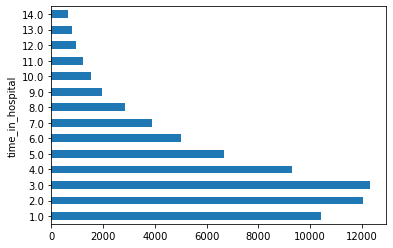

In [170]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     6211
2.0     7174
3.0     7455
4.0     5651
5.0     3927
6.0     3044
7.0     2306
8.0     1757
9.0     1163
10.0     908
11.0     729
12.0     564
13.0     452
14.0     394
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


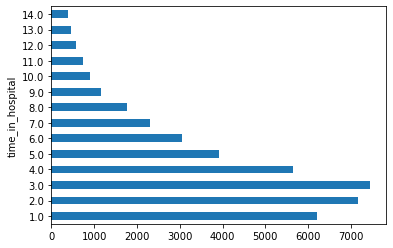

In [171]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     2084
2.0     2438
3.0     2412
4.0     1873
5.0     1375
6.0      982
7.0      770
8.0      552
9.0      390
10.0     301
11.0     253
12.0     186
13.0     164
14.0     132
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


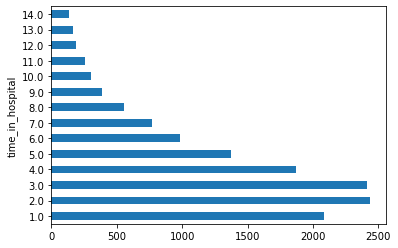

In [172]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female    37042
Male      32517
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


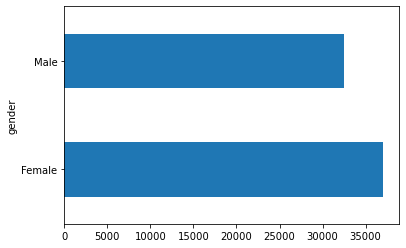

In [173]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female    22239
Male      19496
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


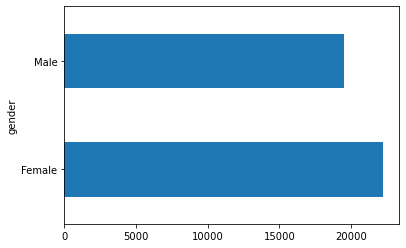

In [174]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female    7385
Male      6527
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


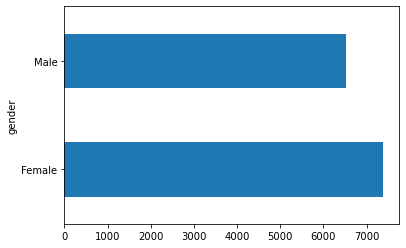

In [175]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [176]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [177]:
diabetes_test_ds

<BatchDataset shapes: ({patient_nbr: (None,), admission_type_id: (None,), discharge_disposition_id: (None,), admission_source_id: (None,), primary_diagnosis_code: (None,), max_glu_serum: (None,), A1Cresult: (None,), change: (None,), race: (None,), gender: (None,), age: (None,), Acarbose: (None,), Glimepiride: (None,), Glipizide: (None,), Glipizide_And_Metformin_Hcl: (None,), Glipizide_And_Metformin_Hydrochloride: (None,), Glyburide: (None,), Glyburide_And_Metformin_Hydrochloride: (None,), Glyburide-metformin_Hydrochloride: (None,), Human_Insulin: (None,), Insulin_Human: (None,), Metformin_Hcl: (None,), Metformin_Hydrochloride: (None,), Miglitol: (None,), Nateglinide: (None,), Pioglitazole_And_Metformin_Hydrochloride: (None,), Pioglitazone: (None,), Pioglitazone_Hydrochloride_And_Glimepiride: (None,), Repaglinide: (None,), Rosiglitazone_Maleate: (None,), Tolazamide: (None,), Tolbutamide: (None,), number_outpatient: (None,), number_inpatient: (None,), number_emergency: (None,), num_lab_p

In [178]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))
diabetes_batch

{'patient_nbr': <tf.Tensor: shape=(128,), dtype=int32, numpy=
 array([ 52120638,  11505870,  69551739,  24166476,  31690548,  84430710,
         62685828,   1039347,  42565014,  76328460,  88917174,  24184143,
         99433881,  97298037,  41858118,  72365148, 107946783,  84308841,
         57863286,  24176709,  94771143,  52388352,  44441073,  90259515,
         28001853,  41130630,   5320917,   4723443, 101959479,  91210617,
         59590242,  39256587,   7249878, 102581838,  89687403,  98465490,
         43147665,  27852858,  21854403,   7097940,  35257203,  68531139,
         18028584,  59597181,  43036614, 160958849,  62189820,  43161903,
         38930319,   5397552, 105436719, 141977588,    402471,  23679081,
         60268032,   6803154,   1702035,  79641594,  33488946,  93500748,
          5838948,  73058634,  10228923, 114689727,  47750724,  78963786,
         23338314,  98151723,  64618560,  59074128,  23508387,  44008740,
         25049718,  43605720, 158480006,  41544864

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [181]:

#ll

In [182]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)
vocab_file_list

['./diabetes_vocab/admission_type_id_vocab.txt',
 './diabetes_vocab/discharge_disposition_id_vocab.txt',
 './diabetes_vocab/admission_source_id_vocab.txt',
 './diabetes_vocab/primary_diagnosis_code_vocab.txt',
 './diabetes_vocab/max_glu_serum_vocab.txt',
 './diabetes_vocab/A1Cresult_vocab.txt',
 './diabetes_vocab/change_vocab.txt',
 './diabetes_vocab/race_vocab.txt',
 './diabetes_vocab/gender_vocab.txt',
 './diabetes_vocab/age_vocab.txt',
 './diabetes_vocab/Acarbose_vocab.txt',
 './diabetes_vocab/Glimepiride_vocab.txt',
 './diabetes_vocab/Glipizide_vocab.txt',
 './diabetes_vocab/Glipizide_And_Metformin_Hcl_vocab.txt',
 './diabetes_vocab/Glipizide_And_Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Glyburide_vocab.txt',
 './diabetes_vocab/Glyburide_And_Metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Glyburide-metformin_Hydrochloride_vocab.txt',
 './diabetes_vocab/Human_Insulin_vocab.txt',
 './diabetes_vocab/Insulin_Human_vocab.txt',
 './diabetes_vocab/Metformin_Hcl_vocab.t

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [183]:
from student_utils import create_tf_categorical_feature_cols
%load_ext autoreload
%autoreload
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO:tensorflow:vocabulary_size = 9 in admission_type_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_type_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 27 in discharge_disposition_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/discharge_disposition_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 16 in admission_source_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_source_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 660 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 5 in max_glu_serum is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/max_glu_serum_vocab.txt.
INFO:tensorflow:vocabulary_size = 5 in A1Cresult is inferr

In [184]:
tf_cat_col_list

[IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='admission_type_id', vocabulary_file='./diabetes_vocab/admission_type_id_vocab.txt', vocabulary_size=9, num_oov_buckets=1, dtype=tf.string, default_value=-1)),
 IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='discharge_disposition_id', vocabulary_file='./diabetes_vocab/discharge_disposition_id_vocab.txt', vocabulary_size=27, num_oov_buckets=1, dtype=tf.string, default_value=-1)),
 IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='admission_source_id', vocabulary_file='./diabetes_vocab/admission_source_id_vocab.txt', vocabulary_size=16, num_oov_buckets=1, dtype=tf.string, default_value=-1)),
 EmbeddingColumn(categorical_column=VocabularyFileCategoricalColumn(key='primary_diagnosis_code', vocabulary_file='./diabetes_vocab/primary_diagnosis_code_vocab.txt', vocabulary_size=660, num_oov_buckets=1, dtype=tf.string, default_value=-1), dimension=8, combiner='mean', initializer

In [185]:
test_cat_var1 = tf_cat_col_list[5]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='A1Cresult', vocabulary_file='./diabetes_vocab/A1Cresult_vocab.txt', vocabulary_size=5, num_oov_buckets=1, dtype=tf.string, default_value=-1))
tf.Tensor(
[[0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0.

# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [186]:
d_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41735 entries, 23830 to 54986
Data columns (total 40 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   patient_nbr                                 41735 non-null  int64  
 1   time_in_hospital                            41735 non-null  float64
 2   admission_type_id                           41735 non-null  object 
 3   discharge_disposition_id                    41735 non-null  object 
 4   admission_source_id                         41735 non-null  object 
 5   primary_diagnosis_code                      41735 non-null  object 
 6   max_glu_serum                               41735 non-null  object 
 7   A1Cresult                                   41735 non-null  object 
 8   change                                      41735 non-null  object 
 9   race                                        41735 non-null  object 
 10  gender

In [187]:
from student_utils import create_tf_numeric_feature
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [188]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        print(mean,std)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std,default_value=0)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [189]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

0.28180184497424227 1.0681786456159696
0.17656643105307296 0.5898431458717809
0.10559482448783994 0.5444193938148875
43.12100155744579 19.975886972490905
7.262729124236253 1.983604232575535
15.691649694501018 8.305205730588817
1.432131304660357 1.759266533477442


In [190]:
diabetes_batch

{'patient_nbr': <tf.Tensor: shape=(128,), dtype=int32, numpy=
 array([ 52120638,  11505870,  69551739,  24166476,  31690548,  84430710,
         62685828,   1039347,  42565014,  76328460,  88917174,  24184143,
         99433881,  97298037,  41858118,  72365148, 107946783,  84308841,
         57863286,  24176709,  94771143,  52388352,  44441073,  90259515,
         28001853,  41130630,   5320917,   4723443, 101959479,  91210617,
         59590242,  39256587,   7249878, 102581838,  89687403,  98465490,
         43147665,  27852858,  21854403,   7097940,  35257203,  68531139,
         18028584,  59597181,  43036614, 160958849,  62189820,  43161903,
         38930319,   5397552, 105436719, 141977588,    402471,  23679081,
         60268032,   6803154,   1702035,  79641594,  33488946,  93500748,
          5838948,  73058634,  10228923, 114689727,  47750724,  78963786,
         23338314,  98151723,  64618560,  59074128,  23508387,  44008740,
         25049718,  43605720, 158480006,  41544864

In [191]:
test_cont_var1 = tf_cont_col_list[1]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='number_inpatient', shape=(1,), default_value=(0,), dtype=tf.float32, normalizer_fn=None)

tf.Tensor(
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [2.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(128, 1), dtype=float32)


# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [192]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [195]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mae'):
    model = build_sequential_model(feature_layer)
    negloglik = lambda y, rv_y: -rv_y.log_prob(y)
    loss = negloglik
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=loss, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=5)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [196]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=15)

Train for 327 steps, validate for 109 steps
Epoch 1/15
327/327 [==============================] - 14s 44ms/step - loss: 29.7056 - mae: 2.8076 - val_loss: 9.4923 - val_mae: 2.0006
Epoch 2/15
327/327 [==============================] - 10s 30ms/step - loss: 8.9280 - mae: 1.9363 - val_loss: 8.7376 - val_mae: 1.9455
Epoch 3/15
327/327 [==============================] - 10s 31ms/step - loss: 8.6785 - mae: 1.9485 - val_loss: 8.5906 - val_mae: 2.0648
Epoch 4/15
327/327 [==============================] - 10s 31ms/step - loss: 8.2286 - mae: 1.9249 - val_loss: 8.6013 - val_mae: 1.9811
Epoch 5/15
327/327 [==============================] - 10s 30ms/step - loss: 8.1439 - mae: 1.9190 - val_loss: 8.6158 - val_mae: 2.1189
Epoch 6/15
327/327 [==============================] - 10s 31ms/step - loss: 7.9895 - mae: 1.8988 - val_loss: 8.7186 - val_mae: 1.9808
Epoch 7/15
327/327 [==============================] - 10s 30ms/step - loss: 7.9590 - mae: 1.9147 - val_loss: 7.7640 - val_mae: 1.9004
Epoch 8/15
327/32

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [197]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhats = [diabetes_model(diabetes_x_tst) for _ in range(10)]
preds = diabetes_model.predict(diabetes_test_ds)

In [198]:
from student_utils import get_mean_std_from_preds
%load_ext autoreload
%autoreload
m, s = get_mean_std_from_preds(diabetes_yhats)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Show Prediction Output 

In [199]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.flatten(),
    "pred_std": s.flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [200]:
prob_output_df.head(20)

,pred,actual_value,pred_mean,pred_std
0,4.043047,4.0,3.430912,0.747621
1,3.164367,4.0,1.187464,0.717206
2,2.729237,8.0,7.024511,0.798222
3,6.163214,6.0,8.165696,0.814750
4,5.342132,8.0,4.989985,0.769303
5,1.805672,5.0,4.507336,0.762547
6,6.059729,3.0,3.575301,0.749611
7,6.002910,4.0,1.187464,0.717206
8,7.411670,5.0,1.187464,0.717206
9,1.932606,1.0,1.187464,0.717206


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [201]:

from student_utils import get_student_binary_prediction
%load_ext autoreload
%autoreload
student_binary_prediction = get_student_binary_prediction(d_test,m)
student_binary_prediction

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


array([0, 0, 1, ..., 1, 1, 1])

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [202]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [203]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head(15)

,patient_nbr,gender,race,time_in_hospital,score,label_value
48553,85326795,Male,Caucasian,4.0,0,0
31022,107886231,Female,Caucasian,4.0,0,0
55234,104008356,Male,Other,8.0,1,1
17282,6463575,Male,Caucasian,6.0,1,1
6677,18931644,Male,AfricanAmerican,8.0,1,1
36231,95102190,Female,Caucasian,5.0,1,1
32097,63240912,Female,Caucasian,3.0,0,0
6004,23653035,Female,Caucasian,4.0,0,0
41039,85899870,Male,Caucasian,5.0,0,1
69464,41106078,Female,AfricanAmerican,1.0,0,0


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [204]:
from sklearn.metrics import brier_score_loss, accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve

In [205]:
f1_score(pred_test_df['label_value'], pred_test_df['score'], average='weighted')

0.7652534543938853

In [206]:
roc_auc_score(pred_test_df['label_value'], pred_test_df['score'])

0.7529492667160961

In [207]:
print(classification_report(pred_test_df['label_value'], pred_test_df['score']))


              precision    recall  f1-score   support

           0       0.83      0.79      0.81      8807
           1       0.67      0.71      0.69      5105

    accuracy                           0.76     13912
   macro avg       0.75      0.75      0.75     13912
weighted avg       0.77      0.76      0.77     13912



# Summary
## AUC, F1, precision and recall
### 1- ROC AUC
the ROC AUC relations is used to compare different algorithm performance depending on calculating the area under the curve of the AUC plot.As long as this area increases, this means that the algorithm is performing better and that the TPR and FPR both are better in one algorithm than another. 
The result in our case = 0.7262468962506119. If another architecture of the model was tried and this number increased. this gives an indication that the new model is doing better.

### 1- F1 Score 
the overall F1 score =0.75 which gives an overall bet the average precision and recall of each class and the more this value is near one, this gives an indication that the model performance is getting better.
### 2- Class Precision, Recall
from the results, the overall Precision = 0.75 and the overall recall = 0.75, this means that over the model classes the FP=FN.
class 0: the result of the precision = 0.79 and the recall=0.84 meaning that the FP is slightly higher than FN in this class
class 1: the result of the precision = 0.68 and the recall=0.61 meaning that the FN is slightly higher than FP in this class
### non-technical overview
because the main goal is to choose patients that can decrease the costs for the company as possible, in this case, it's more important to avoid any False Positive results rather than the False Negatives, this means that if the model it's better for the model to predict that higher percentage of the patient will require more costs rather than predicting more people will require lower costs compared to the real values.
As a result, this means that the recall should be as high as possible and is more important than the precision
### future improvements
for future improvements, there is many parts that can be optimized to give better results like
1 - VariationalGaussianProcess layer can be added instead of the normal distribution layer in the model, this can give us a better probability for the mean and standard deviation increasing the overall performance of the model
2- the architecture of the model can be improved by looking to more architectures that have been built by the community for a similar problem
3- batch_normalization can be added to increase the speed, accuracy in the training process
4- trying to reduce the unnecessary numerical, categorical features as possible can lead to increasing the performance of the model


# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [208]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)


model_id, score_thresholds 1 {'rank_abs': [5456]}


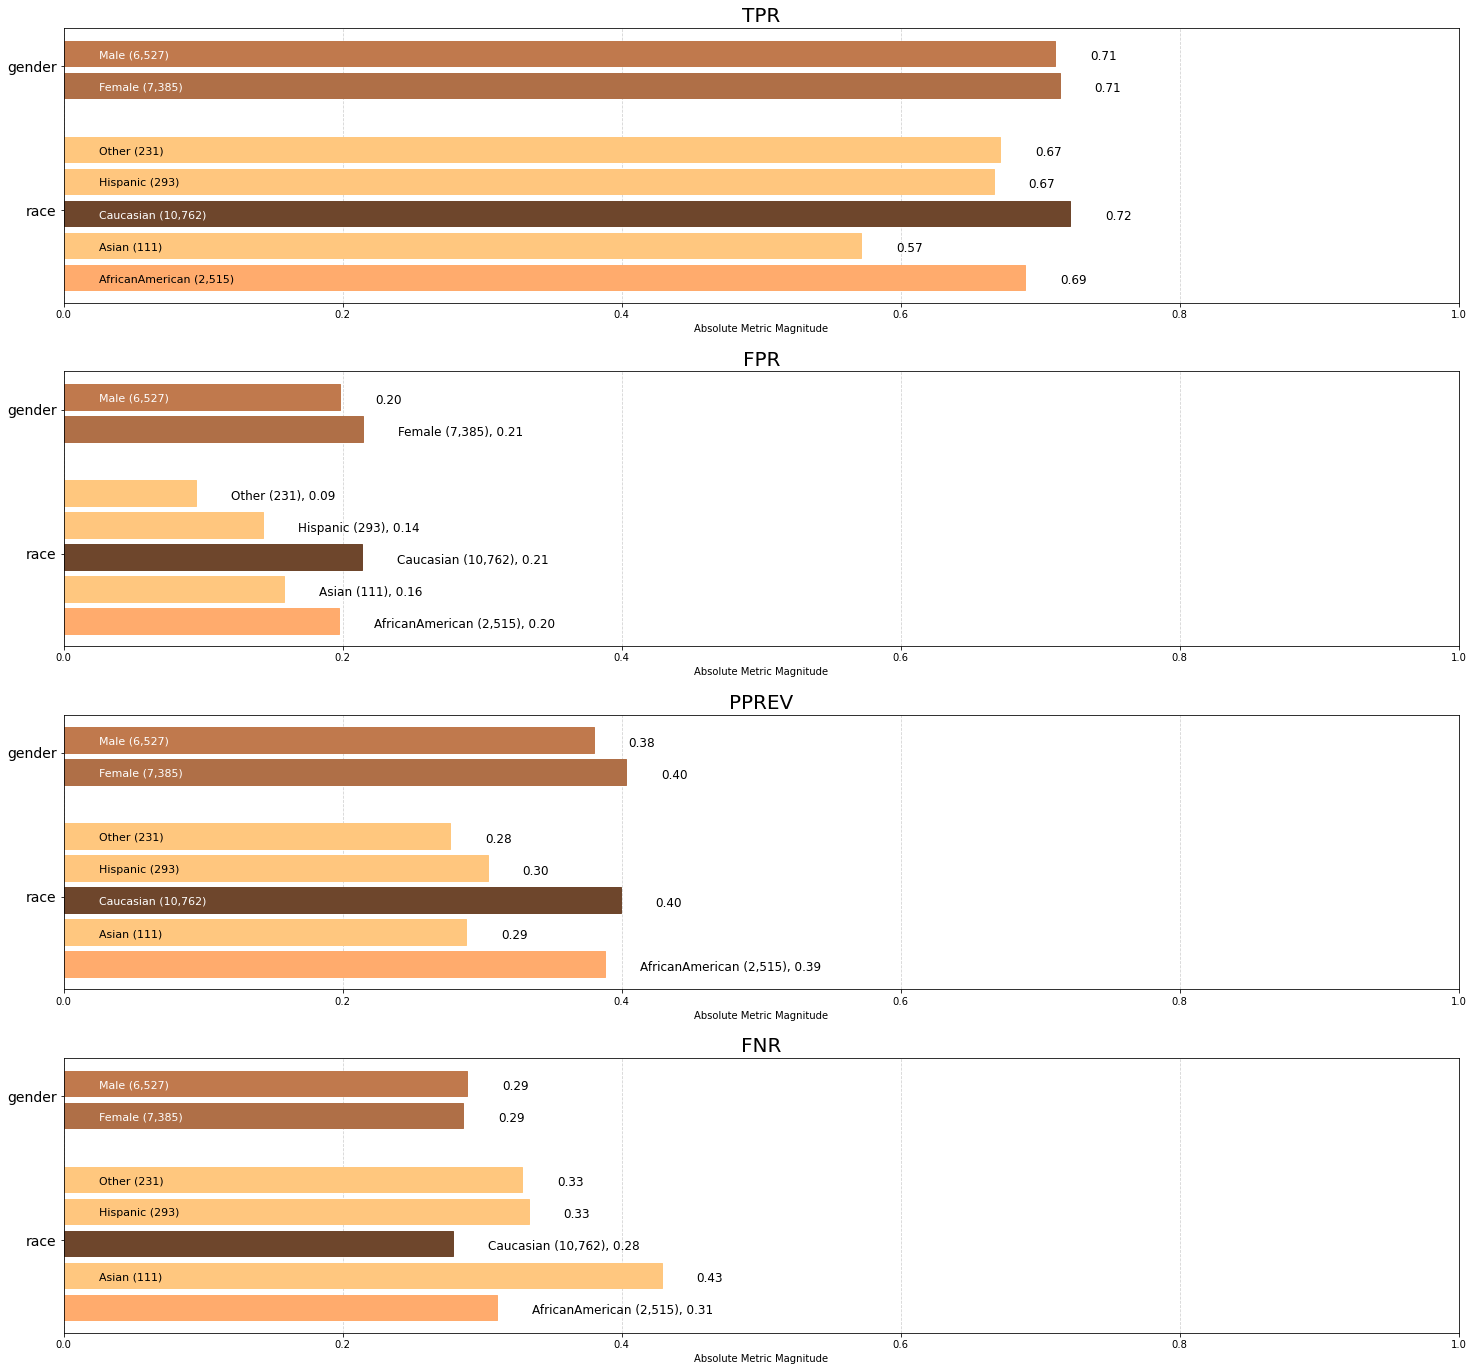

In [209]:
p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fpr', 'pprev', 'fnr'], ncols=1)

## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [210]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

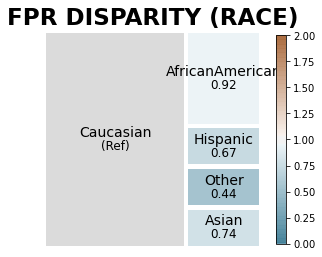

In [211]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='race')


### there is no significant bias in race field compared to the reference group

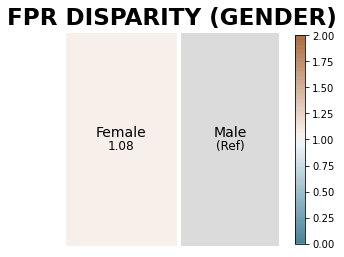

In [212]:
fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                       attribute_name='gender')

### there is no significant bias in gender field compared to the reference group too

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

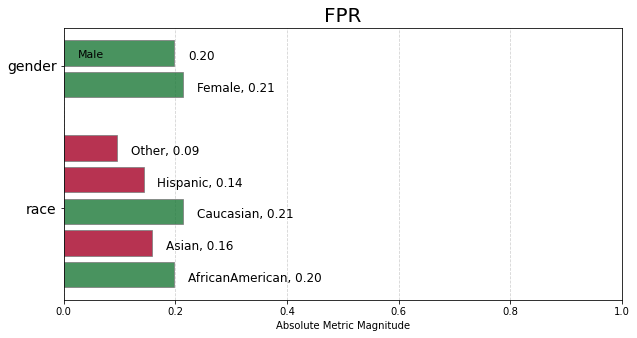

In [213]:
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

### from the results, the FPR in selected group keys are almost the same. This means that there is no bias in this group